In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image
from torchvision import models

device = torch.device('cuda')

In [2]:
import random

def random_erasing(image, probability=0.5, sl=0.02, sh=0.33, r1=0.3):
    """
    Randomly erases a rectangular region of the image.
    
    Args:
        image (PIL Image or Tensor): The input image.
        probability (float): Probability of applying random erasing.
        sl (float): Minimum proportion of erased area against the original area.
        sh (float): Maximum proportion of erased area against the original area.
        r1 (float): Aspect ratio of the erased area.
        
    Returns:
        The modified image with a random erasure applied.
    """
    if random.random() > probability:
        return image  # Do nothing if not applying random erasing

    # Get dimensions
    h, w = image.size if isinstance(image, Image.Image) else image.shape[1:3]
    area = h * w

    # Calculate the target area of the erasure
    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)

    # Calculate the height and width of the rectangle
    h_eraser = int(round((target_area * aspect_ratio) ** 0.5))
    w_eraser = int(round((target_area / aspect_ratio) ** 0.5))

    # Ensure the rectangle fits within the image
    if h_eraser > h or w_eraser > w:
        return image

    # Randomly choose the top left corner of the rectangle
    x = random.randint(0, w - w_eraser)
    y = random.randint(0, h - h_eraser)

    # Create a random erasing mask
    if isinstance(image, Image.Image):
        # Convert image to numpy array for erasing
        image = np.array(image)
    else:
        image = image.numpy()  # If tensor, convert to numpy

    image[y:y + h_eraser, x:x + w_eraser, :] = np.random.randint(0, 256, (h_eraser, w_eraser, 3), dtype=np.uint8)

    return image


In [3]:
class Cifar100Custom(Dataset):
    def __init__(self, root='./data', train=True, transform=None, normal_class=0):
        """
            Custom Cifar100 dataset with normal and abnormal labels.
            Normal class will be labeled as 0, all other classes as 1.
            Parameters:
            - root: Path to the dataset.
            - train: Boolean indicating whether to load the training set (default is True).
            - transform: Transformations to be applied to the images (default is None).
            - normal_class: Class index to be labeled as normal (default is 0).
            - apply_erasing: Boolean indicating whether to apply random erasing (default is False).
        """
        self.dataset = datasets.CIFAR100(root=root, train=train, download=True)
        self.normal_class = normal_class  # Set the normal class (e.g., apple)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Label normal (apple) as 0, abnormal (other) as 1
        label = 0 if label == self.normal_class else 1

        img = random_erasing(img)  # Apply random erasing

        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
# class SSAE_ResNet(nn.Module):
#     def __init__(self, latent_dim=64):
#         super(SSAE_ResNet, self).__init__()

#         # Use a pre-trained ResNet18 as the encoder
#         resnet = models.resnet18(pretrained=True)
#         self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer (fc)
        
#         # Add a fully connected layer to reduce the ResNet output to latent dimensions
#         self.fc_encoder = nn.Linear(resnet.fc.in_features, latent_dim)
        
#         # Decoder network: reconstruct the image from the latent dimensions
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, 32 * 32 * 3),
#             nn.Sigmoid()  # Sigmoid to ensure pixel values are between 0 and 1
#         )

#     def forward(self, x):
#         # Pass through the ResNet-based encoder (without the classification layer)
#         x = self.encoder(x)
        
#         # Flatten the output from the encoder
#         x = x.view(x.size(0), -1)
        
#         # Reduce to the latent dimension
#         x = self.fc_encoder(x)
        
#         # Pass through the decoder
#         x = self.decoder(x)
        
#         # Reshape to (batch_size, 3, 32, 32)
#         x = x.view(x.size(0), 3, 32, 32)
        
#         return x
    
#     def semi_supervised_loss(self, inputs, outputs, labels, margin=0.2):
#         # Flatten the inputs and outputs for loss calculation
#         inputs = inputs.view(inputs.size(0), -1)
#         outputs = outputs.view(outputs.size(0), -1)

#         # Standard reconstruction loss (Mean Squared Error)
#         reconstruction_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)

#         # Separate normal and abnormal samples
#         abnormal = labels > 0  # True for abnormal samples

#         # Calculate additional abnormal loss
#         abnormal_loss = reconstruction_loss[abnormal].mean() if abnormal.any() else torch.tensor(0.0)

#         # Combine normal reconstruction loss and abnormal loss
#         return reconstruction_loss.mean() + abnormal_loss

In [5]:
class SSAE_ResNet(nn.Module):
    def __init__(self, latent_dim=64):
        super(SSAE_ResNet, self).__init__()

        # Use a pre-trained ResNet18 as the encoder
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer (fc)
        
        # Add a fully connected layer to reduce the ResNet output to latent dimensions
        self.fc_encoder = nn.Linear(resnet.fc.in_features, latent_dim)
        
        # Decoder network: reconstruct the image from the latent dimensions
        self.fc_decoder = nn.Linear(latent_dim, 512*4*4)   # Adjusted to produce a 512x4x4 feature map

        # Using a ResNet-like architecture in the decoder (with transposed convolutions)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),     # 128x128
            nn.Sigmoid()  # Sigmoid to ensure pixel values are between 0 and 1
        )

    def forward(self, x):
        # Pass through the ResNet-based encoder (without the classification layer)
        x = self.encoder(x)
        # print("Encoder output shape: ", x.shape)
        
        # Flatten the output from the encoder
        x = x.view(x.size(0), -1)
        # print("Flattened shape: ",x.shape)
        
        # Reduce to the latent dimension
        x = self.fc_encoder(x)
        # print("Latent dimension shape: ",x.shape)

        
        # Pass through the first fully connected layer for the decoder
        x = self.fc_decoder(x)
        # print("Shape before reshaping for decoder: ",x.shape)
        
        # Dynamically calculate the reshape size for the decoder
        batch_size = x.size(0)
        feature_map_size = int((x.size(1) // 512) ** 0.5)  # Assuming the decoder starts with 512 channels
        # print(f"Feature map size: {feature_map_size}x{feature_map_size}")
        
        # Reshape to start decoding (batch_size, 512, feature_map_size, feature_map_size)
        x = x.view(batch_size, 512, feature_map_size, feature_map_size)
        # print("Reshaped for decoder:", x.shape)  # Shape ready for the decoder

        # Pass through the ResNet-like decoder
        x = self.decoder(x)
        # print("Decoder output shape: ",x.shape)

        
        return x
    
    def semi_supervised_loss(self, inputs, outputs, labels, margin=0.2):
        # Flatten the inputs and outputs for loss calculation
        inputs = inputs.view(inputs.size(0), -1)
        outputs = outputs.view(outputs.size(0), -1)

        # Standard reconstruction loss (Mean Squared Error)
        reconstruction_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)

        # Separate normal and abnormal samples
        abnormal = labels > 0  # True for abnormal samples

        # Calculate additional abnormal loss
        abnormal_loss = reconstruction_loss[abnormal].mean() if abnormal.any() else torch.tensor(0.0)

        # Combine normal reconstruction loss and abnormal loss
        return reconstruction_loss.mean() + abnormal_loss

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                # Normalization according to CIFAR-100 mean and std
                                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
train_dataset = Cifar100Custom(train=True, transform=transform, normal_class=0)  # apple as normal
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = Cifar100Custom(train=False, transform=transform, normal_class=0)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        img, label = dataset[i]  # Get image and label
        
        # Convert tensor to numpy array for displaying
        if isinstance(img, torch.Tensor):
            # img = img.numpy().squeeze()  # Convert to numpy and squeeze to remove extra dimensions

             img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format

        axes[i].imshow(img, cmap='gray')  # Display the image
        axes[i].set_title(f"Label: {'Normal' if label == 0 else 'Abnormal'}")
        axes[i].axis('off')
    
    plt.show()

Files already downloaded and verified
Total number of samples in the dataset: 50000


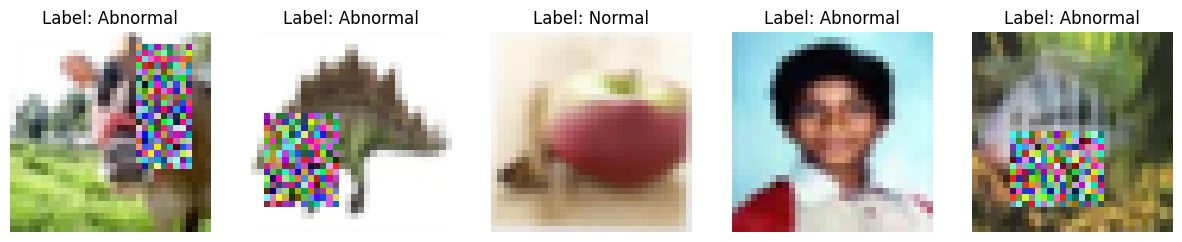

In [8]:
# Dataset with T-shirts (class 0) as normal and others as abnormal
train_dataset = Cifar100Custom(train=True, transform=transforms.ToTensor(), normal_class=0)

# Check the length of the dataset
print(f"Total number of samples in the dataset: {len(train_dataset)}")

# Show a few samples with their labels
show_samples(train_dataset, num_samples=5)

In [9]:
model = SSAE_ResNet()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Initialize the ReduceLROnPlateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-6
)

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model.to(device)

SSAE_ResNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [11]:
# List to store loss values for plotting
loss_values = []
val_loss_values = []

# variable initialization to store the best validation loss
best_val_loss = float('inf')

for epoch in range(100):
    model.train()  # model in training mode
    total_loss = 0
    
    # tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/100 (SSAE)")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        # Flatten the images for the autoencoder
        # images = images.view(-1, 3*32*32)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = model.semi_supervised_loss(images, outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update tqdm progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())
    
    # Calculate the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    
    # Print the average loss for the current epoch
    print(f"Epoch [{epoch+1}/100], Avg Loss: {avg_loss:.4f}")
    
    
    # --- Validation loop ---
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_images, val_labels in val_loader:

            val_images, val_labels = val_images.to(device), val_labels.to(device)
            
            # Flatten the validation images
            # val_images = val_images.view(-1, 3*32*32)
            
            # Forward pass
            val_outputs = model(val_images)
            
            # Calculate validation loss
            val_loss = model.semi_supervised_loss(val_images, val_outputs, val_labels)
            total_val_loss += val_loss.item()
    
    # Calculate the average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # Print the average validation loss for the current epoch
    print(f"Epoch [{epoch+1}/100], Avg Validation Loss: {avg_val_loss:.4f}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)
    
    # --- Model selection based on validation loss ---
    if avg_val_loss < best_val_loss and (epoch+1) % 5 == 0:
        best_val_loss = avg_val_loss
        print(f"Validation loss improved. Saving the best model at epoch {epoch+1}.")
        torch.save(model.state_dict(), f'model_ssae_resnet_cifar100/best_model_epoch_{epoch+1}.pth')
    
    # Save the model after each epoch
    # torch.save(model.state_dict(), f'model_ssae_cifar100/ssae_cifar_epoch_{epoch+1}.pth')


Epoch 1/100 (SSAE): 100%|██████████| 98/98 [00:59<00:00,  1.64it/s, loss=1.57]


Epoch [1/100], Avg Loss: 1.7503
Epoch [1/100], Avg Validation Loss: 1.5677


Epoch 2/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.51]


Epoch [2/100], Avg Loss: 1.5090
Epoch [2/100], Avg Validation Loss: 1.4788


Epoch 3/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.40it/s, loss=1.4] 


Epoch [3/100], Avg Loss: 1.4484
Epoch [3/100], Avg Validation Loss: 1.4386


Epoch 4/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.49it/s, loss=1.43]


Epoch [4/100], Avg Loss: 1.4198
Epoch [4/100], Avg Validation Loss: 1.4173


Epoch 5/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.36it/s, loss=1.39]


Epoch [5/100], Avg Loss: 1.3986
Epoch [5/100], Avg Validation Loss: 1.3988
Validation loss improved. Saving the best model at epoch 5.


Epoch 6/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.46it/s, loss=1.39]


Epoch [6/100], Avg Loss: 1.3835
Epoch [6/100], Avg Validation Loss: 1.3813


Epoch 7/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.43it/s, loss=1.33]


Epoch [7/100], Avg Loss: 1.3716
Epoch [7/100], Avg Validation Loss: 1.3720


Epoch 8/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.48it/s, loss=1.38]


Epoch [8/100], Avg Loss: 1.3632
Epoch [8/100], Avg Validation Loss: 1.3679


Epoch 9/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.37it/s, loss=1.39]


Epoch [9/100], Avg Loss: 1.3566
Epoch [9/100], Avg Validation Loss: 1.3615


Epoch 10/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.46it/s, loss=1.34]


Epoch [10/100], Avg Loss: 1.3490
Epoch [10/100], Avg Validation Loss: 1.3542
Validation loss improved. Saving the best model at epoch 10.


Epoch 11/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.3] 


Epoch [11/100], Avg Loss: 1.3452
Epoch [11/100], Avg Validation Loss: 1.3520


Epoch 12/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.36]


Epoch [12/100], Avg Loss: 1.3412
Epoch [12/100], Avg Validation Loss: 1.3457


Epoch 13/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.33]


Epoch [13/100], Avg Loss: 1.3356
Epoch [13/100], Avg Validation Loss: 1.3453


Epoch 14/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.43it/s, loss=1.36]


Epoch [14/100], Avg Loss: 1.3331
Epoch [14/100], Avg Validation Loss: 1.3409


Epoch 15/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.42it/s, loss=1.36]


Epoch [15/100], Avg Loss: 1.3319
Epoch [15/100], Avg Validation Loss: 1.3353
Validation loss improved. Saving the best model at epoch 15.


Epoch 16/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.42it/s, loss=1.38]


Epoch [16/100], Avg Loss: 1.3285
Epoch [16/100], Avg Validation Loss: 1.3365


Epoch 17/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.44it/s, loss=1.29]


Epoch [17/100], Avg Loss: 1.3244
Epoch [17/100], Avg Validation Loss: 1.3343


Epoch 18/100 (SSAE): 100%|██████████| 98/98 [01:06<00:00,  1.48it/s, loss=1.33]


Epoch [18/100], Avg Loss: 1.3213
Epoch [18/100], Avg Validation Loss: 1.3279


Epoch 19/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.37it/s, loss=1.33]


Epoch [19/100], Avg Loss: 1.3194
Epoch [19/100], Avg Validation Loss: 1.3255


Epoch 20/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.55it/s, loss=1.33]


Epoch [20/100], Avg Loss: 1.3162
Epoch [20/100], Avg Validation Loss: 1.3232
Validation loss improved. Saving the best model at epoch 20.


Epoch 21/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.36it/s, loss=1.34]


Epoch [21/100], Avg Loss: 1.3146
Epoch [21/100], Avg Validation Loss: 1.3168


Epoch 22/100 (SSAE): 100%|██████████| 98/98 [01:02<00:00,  1.57it/s, loss=1.34]


Epoch [22/100], Avg Loss: 1.3122
Epoch [22/100], Avg Validation Loss: 1.3186


Epoch 23/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.22]


Epoch [23/100], Avg Loss: 1.3088
Epoch [23/100], Avg Validation Loss: 1.3181


Epoch 24/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.25]


Epoch [24/100], Avg Loss: 1.3065
Epoch [24/100], Avg Validation Loss: 1.3120


Epoch 25/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.41it/s, loss=1.28]


Epoch [25/100], Avg Loss: 1.3043
Epoch [25/100], Avg Validation Loss: 1.3144
Validation loss improved. Saving the best model at epoch 25.


Epoch 26/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.25]


Epoch [26/100], Avg Loss: 1.3023
Epoch [26/100], Avg Validation Loss: 1.3115


Epoch 27/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.37]


Epoch [27/100], Avg Loss: 1.3010
Epoch [27/100], Avg Validation Loss: 1.3113


Epoch 28/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.50it/s, loss=1.33]


Epoch [28/100], Avg Loss: 1.2998
Epoch [28/100], Avg Validation Loss: 1.3070


Epoch 29/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.42it/s, loss=1.33]


Epoch [29/100], Avg Loss: 1.2984
Epoch [29/100], Avg Validation Loss: 1.3071


Epoch 30/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.46it/s, loss=1.33]


Epoch [30/100], Avg Loss: 1.2968
Epoch [30/100], Avg Validation Loss: 1.3043
Validation loss improved. Saving the best model at epoch 30.


Epoch 31/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.44it/s, loss=1.35]


Epoch [31/100], Avg Loss: 1.2956
Epoch [31/100], Avg Validation Loss: 1.3065


Epoch 32/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.43it/s, loss=1.35]


Epoch [32/100], Avg Loss: 1.2937
Epoch [32/100], Avg Validation Loss: 1.3066


Epoch 33/100 (SSAE): 100%|██████████| 98/98 [01:06<00:00,  1.47it/s, loss=1.32]


Epoch [33/100], Avg Loss: 1.2937
Epoch [33/100], Avg Validation Loss: 1.3013


Epoch 34/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.51it/s, loss=1.3] 


Epoch [34/100], Avg Loss: 1.2929
Epoch [34/100], Avg Validation Loss: 1.3054


Epoch 35/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.44it/s, loss=1.26]


Epoch [35/100], Avg Loss: 1.2897
Epoch [35/100], Avg Validation Loss: 1.2991
Validation loss improved. Saving the best model at epoch 35.


Epoch 36/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.49it/s, loss=1.22]


Epoch [36/100], Avg Loss: 1.2883
Epoch [36/100], Avg Validation Loss: 1.3002


Epoch 37/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.43it/s, loss=1.23]


Epoch [37/100], Avg Loss: 1.2874
Epoch [37/100], Avg Validation Loss: 1.2976


Epoch 38/100 (SSAE): 100%|██████████| 98/98 [01:06<00:00,  1.48it/s, loss=1.24]


Epoch [38/100], Avg Loss: 1.2870
Epoch [38/100], Avg Validation Loss: 1.2952


Epoch 39/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.27]


Epoch [39/100], Avg Loss: 1.2874
Epoch [39/100], Avg Validation Loss: 1.2985


Epoch 40/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.50it/s, loss=1.26]


Epoch [40/100], Avg Loss: 1.2847
Epoch [40/100], Avg Validation Loss: 1.2972
Validation loss improved. Saving the best model at epoch 40.


Epoch 41/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.27]


Epoch [41/100], Avg Loss: 1.2851
Epoch [41/100], Avg Validation Loss: 1.2961


Epoch 42/100 (SSAE): 100%|██████████| 98/98 [01:06<00:00,  1.47it/s, loss=1.35]


Epoch [42/100], Avg Loss: 1.2856
Epoch [42/100], Avg Validation Loss: 1.2966


Epoch 43/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.43it/s, loss=1.25]


Epoch [43/100], Avg Loss: 1.2829
Epoch [43/100], Avg Validation Loss: 1.2955


Epoch 44/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.52it/s, loss=1.33]


Epoch [44/100], Avg Loss: 1.2838
Epoch [44/100], Avg Validation Loss: 1.2979


Epoch 45/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.40it/s, loss=1.3] 


Epoch [45/100], Avg Loss: 1.2820
Epoch [45/100], Avg Validation Loss: 1.2961
Validation loss improved. Saving the best model at epoch 45.


Epoch 46/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.52it/s, loss=1.26]


Epoch [46/100], Avg Loss: 1.2819
Epoch [46/100], Avg Validation Loss: 1.2946


Epoch 47/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.32]


Epoch [47/100], Avg Loss: 1.2809
Epoch [47/100], Avg Validation Loss: 1.2947


Epoch 48/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.52it/s, loss=1.3] 


Epoch [48/100], Avg Loss: 1.2804
Epoch [48/100], Avg Validation Loss: 1.2923


Epoch 49/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.40it/s, loss=1.3] 


Epoch [49/100], Avg Loss: 1.2812
Epoch [49/100], Avg Validation Loss: 1.2945


Epoch 50/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.53it/s, loss=1.27]


Epoch [50/100], Avg Loss: 1.2806
Epoch [50/100], Avg Validation Loss: 1.2885
Validation loss improved. Saving the best model at epoch 50.


Epoch 51/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.40it/s, loss=1.3] 


Epoch [51/100], Avg Loss: 1.2795
Epoch [51/100], Avg Validation Loss: 1.2919


Epoch 52/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.52it/s, loss=1.28]


Epoch [52/100], Avg Loss: 1.2801
Epoch [52/100], Avg Validation Loss: 1.2942


Epoch 53/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.41it/s, loss=1.27]


Epoch [53/100], Avg Loss: 1.2797
Epoch [53/100], Avg Validation Loss: 1.2899


Epoch 54/100 (SSAE): 100%|██████████| 98/98 [01:02<00:00,  1.57it/s, loss=1.27]


Epoch [54/100], Avg Loss: 1.2784
Epoch [54/100], Avg Validation Loss: 1.2946


Epoch 55/100 (SSAE): 100%|██████████| 98/98 [01:12<00:00,  1.35it/s, loss=1.26]


Epoch [55/100], Avg Loss: 1.2798
Epoch [55/100], Avg Validation Loss: 1.2891


Epoch 56/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.52it/s, loss=1.27]


Epoch [56/100], Avg Loss: 1.2774
Epoch [56/100], Avg Validation Loss: 1.2917


Epoch 57/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.37it/s, loss=1.26]


Epoch [57/100], Avg Loss: 1.2798
Epoch [57/100], Avg Validation Loss: 1.2915


Epoch 58/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.54it/s, loss=1.23]


Epoch [58/100], Avg Loss: 1.2792
Epoch [58/100], Avg Validation Loss: 1.2919


Epoch 59/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.31]


Epoch [59/100], Avg Loss: 1.2797
Epoch [59/100], Avg Validation Loss: 1.2931


Epoch 60/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.53it/s, loss=1.31]


Epoch [60/100], Avg Loss: 1.2797
Epoch [60/100], Avg Validation Loss: 1.2924


Epoch 61/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.43it/s, loss=1.31]


Epoch [61/100], Avg Loss: 1.2794
Epoch [61/100], Avg Validation Loss: 1.2945


Epoch 62/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.52it/s, loss=1.3] 


Epoch [62/100], Avg Loss: 1.2774
Epoch [62/100], Avg Validation Loss: 1.2906


Epoch 63/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.42it/s, loss=1.27]


Epoch [63/100], Avg Loss: 1.2761
Epoch [63/100], Avg Validation Loss: 1.2924


Epoch 64/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.50it/s, loss=1.31]


Epoch [64/100], Avg Loss: 1.2778
Epoch [64/100], Avg Validation Loss: 1.2888


Epoch 65/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.34]


Epoch [65/100], Avg Loss: 1.2775
Epoch [65/100], Avg Validation Loss: 1.2937


Epoch 66/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.55it/s, loss=1.27]


Epoch [66/100], Avg Loss: 1.2779
Epoch [66/100], Avg Validation Loss: 1.2908


Epoch 67/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.37it/s, loss=1.31]


Epoch [67/100], Avg Loss: 1.2780
Epoch [67/100], Avg Validation Loss: 1.2909


Epoch 68/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.55it/s, loss=1.27]


Epoch [68/100], Avg Loss: 1.2778
Epoch [68/100], Avg Validation Loss: 1.2912


Epoch 69/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.2] 


Epoch [69/100], Avg Loss: 1.2771
Epoch [69/100], Avg Validation Loss: 1.2943


Epoch 70/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.50it/s, loss=1.32]


Epoch [70/100], Avg Loss: 1.2774
Epoch [70/100], Avg Validation Loss: 1.2914


Epoch 71/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.40it/s, loss=1.27]


Epoch [71/100], Avg Loss: 1.2759
Epoch [71/100], Avg Validation Loss: 1.2919


Epoch 72/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.55it/s, loss=1.29]


Epoch [72/100], Avg Loss: 1.2780
Epoch [72/100], Avg Validation Loss: 1.2920


Epoch 73/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.38it/s, loss=1.25]


Epoch [73/100], Avg Loss: 1.2785
Epoch [73/100], Avg Validation Loss: 1.2898


Epoch 74/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.53it/s, loss=1.29]


Epoch [74/100], Avg Loss: 1.2762
Epoch [74/100], Avg Validation Loss: 1.2910


Epoch 75/100 (SSAE): 100%|██████████| 98/98 [01:13<00:00,  1.34it/s, loss=1.22]


Epoch [75/100], Avg Loss: 1.2766
Epoch [75/100], Avg Validation Loss: 1.2911


Epoch 76/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.55it/s, loss=1.28]


Epoch [76/100], Avg Loss: 1.2766
Epoch [76/100], Avg Validation Loss: 1.2935


Epoch 77/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.28]


Epoch [77/100], Avg Loss: 1.2768
Epoch [77/100], Avg Validation Loss: 1.2901


Epoch 78/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.50it/s, loss=1.23]


Epoch [78/100], Avg Loss: 1.2753
Epoch [78/100], Avg Validation Loss: 1.2905


Epoch 79/100 (SSAE): 100%|██████████| 98/98 [01:10<00:00,  1.39it/s, loss=1.26]


Epoch [79/100], Avg Loss: 1.2770
Epoch [79/100], Avg Validation Loss: 1.2905


Epoch 80/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.50it/s, loss=1.32]


Epoch [80/100], Avg Loss: 1.2784
Epoch [80/100], Avg Validation Loss: 1.2887


Epoch 81/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.44it/s, loss=1.26]


Epoch [81/100], Avg Loss: 1.2755
Epoch [81/100], Avg Validation Loss: 1.2914


Epoch 82/100 (SSAE): 100%|██████████| 98/98 [01:06<00:00,  1.47it/s, loss=1.29]


Epoch [82/100], Avg Loss: 1.2755
Epoch [82/100], Avg Validation Loss: 1.2894


Epoch 83/100 (SSAE): 100%|██████████| 98/98 [01:11<00:00,  1.38it/s, loss=1.24]


Epoch [83/100], Avg Loss: 1.2764
Epoch [83/100], Avg Validation Loss: 1.2881


Epoch 84/100 (SSAE): 100%|██████████| 98/98 [01:06<00:00,  1.47it/s, loss=1.33]


Epoch [84/100], Avg Loss: 1.2773
Epoch [84/100], Avg Validation Loss: 1.2912


Epoch 85/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.41it/s, loss=1.26]


Epoch [85/100], Avg Loss: 1.2767
Epoch [85/100], Avg Validation Loss: 1.2908


Epoch 86/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.49it/s, loss=1.32]


Epoch [86/100], Avg Loss: 1.2756
Epoch [86/100], Avg Validation Loss: 1.2905


Epoch 87/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.44it/s, loss=1.33]


Epoch [87/100], Avg Loss: 1.2764
Epoch [87/100], Avg Validation Loss: 1.2943


Epoch 88/100 (SSAE): 100%|██████████| 98/98 [01:06<00:00,  1.48it/s, loss=1.28]


Epoch [88/100], Avg Loss: 1.2766
Epoch [88/100], Avg Validation Loss: 1.2887


Epoch 89/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.44it/s, loss=1.29]


Epoch [89/100], Avg Loss: 1.2771
Epoch [89/100], Avg Validation Loss: 1.2903


Epoch 90/100 (SSAE): 100%|██████████| 98/98 [01:08<00:00,  1.44it/s, loss=1.27]


Epoch [90/100], Avg Loss: 1.2764
Epoch [90/100], Avg Validation Loss: 1.2919


Epoch 91/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.51it/s, loss=1.26]


Epoch [91/100], Avg Loss: 1.2762
Epoch [91/100], Avg Validation Loss: 1.2889


Epoch 92/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.41it/s, loss=1.18]


Epoch [92/100], Avg Loss: 1.2758
Epoch [92/100], Avg Validation Loss: 1.2929


Epoch 93/100 (SSAE): 100%|██████████| 98/98 [01:05<00:00,  1.49it/s, loss=1.27]


Epoch [93/100], Avg Loss: 1.2766
Epoch [93/100], Avg Validation Loss: 1.2890


Epoch 94/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.33]


Epoch [94/100], Avg Loss: 1.2762
Epoch [94/100], Avg Validation Loss: 1.2896


Epoch 95/100 (SSAE): 100%|██████████| 98/98 [01:07<00:00,  1.45it/s, loss=1.22]


Epoch [95/100], Avg Loss: 1.2768
Epoch [95/100], Avg Validation Loss: 1.2870
Validation loss improved. Saving the best model at epoch 95.


Epoch 96/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.42it/s, loss=1.28]


Epoch [96/100], Avg Loss: 1.2769
Epoch [96/100], Avg Validation Loss: 1.2945


Epoch 97/100 (SSAE): 100%|██████████| 98/98 [01:03<00:00,  1.55it/s, loss=1.24]


Epoch [97/100], Avg Loss: 1.2774
Epoch [97/100], Avg Validation Loss: 1.2941


Epoch 98/100 (SSAE): 100%|██████████| 98/98 [01:12<00:00,  1.34it/s, loss=1.32]


Epoch [98/100], Avg Loss: 1.2774
Epoch [98/100], Avg Validation Loss: 1.2928


Epoch 99/100 (SSAE): 100%|██████████| 98/98 [01:04<00:00,  1.53it/s, loss=1.28]


Epoch [99/100], Avg Loss: 1.2775
Epoch [99/100], Avg Validation Loss: 1.2896


Epoch 100/100 (SSAE): 100%|██████████| 98/98 [01:09<00:00,  1.42it/s, loss=1.24]


Epoch [100/100], Avg Loss: 1.2779
Epoch [100/100], Avg Validation Loss: 1.2895


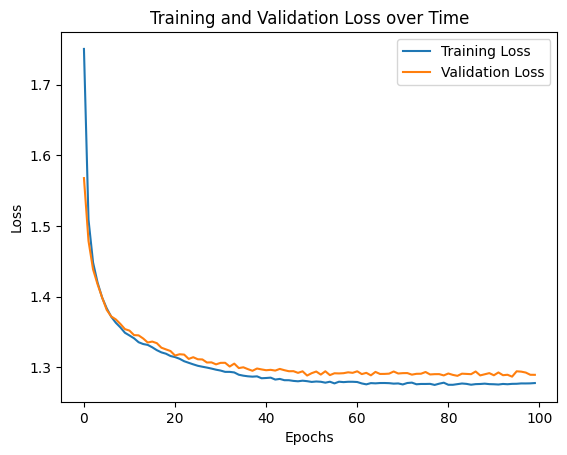

In [13]:
# Plot both training and validation losses
plt.plot(loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

In [14]:
def visualize_reconstruction(model, dataset, num_samples=10, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    model.load_state_dict(torch.load('model_ssae_resnet_cifar100/best_model_epoch_95.pth'))
    model.eval()

    model.to(device)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        img, label = dataset[i]
        # img, label = img.to(device), label.to(device)
        # img = img.view(1, -1).to(device)  # Flatten image
        img = img.unsqueeze(0).to(device)  # Add a batch dimension (1, 3, 32, 32)
        
        # Forward pass to get the reconstruction
        with torch.no_grad():
            img = img.to(device)
            reconstructed_img = model(img)

        # Reshape images back to 28x28 for visualization
        # img = img.view(28, 28)
        # reconstructed_img = reconstructed_img.view(28, 28)
        
        # Reshape images back to 32x32 with 3 channels for visualization
        img = img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C) format
        reconstructed_img = reconstructed_img.squeeze().permute(1, 2, 0).cpu().numpy()  # Reshape and permute back

        
        # Plot original image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Original: {'Normal' if label == 0 else 'Abnormal'}")
        axes[0, i].axis('off')
        
        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_img, cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

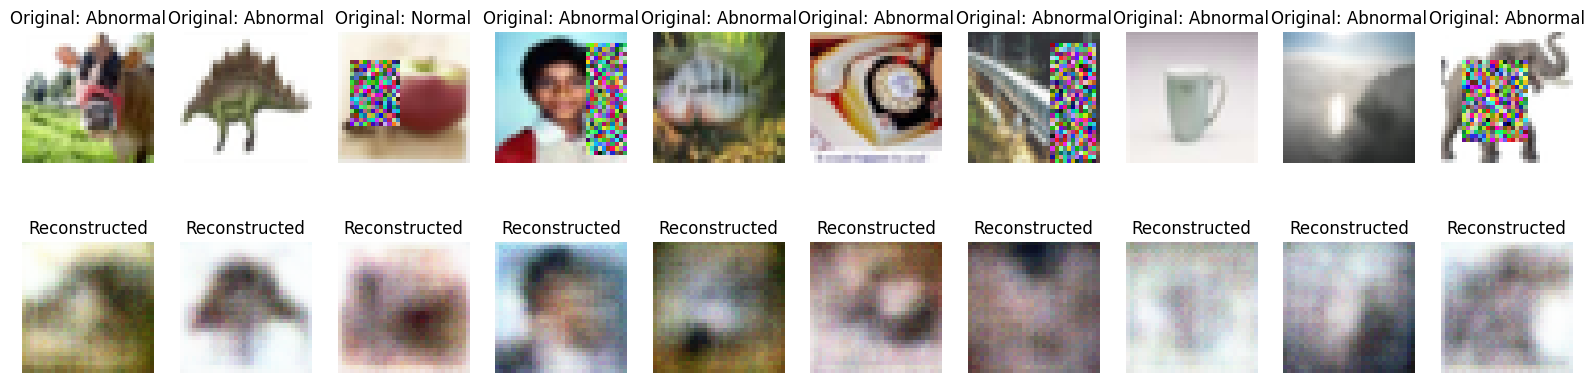

In [15]:
visualize_reconstruction(model, train_dataset, device=device)